In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam

tf.get_logger().setLevel('ERROR')
from sklearn.model_selection import train_test_split

In [2]:
ia_data = pd.read_csv('ia_prep.csv')[500:]
rt_data = pd.read_csv('rt_prep.csv')[500:]
ia_data['target'] = [1]*ia_data.shape[0]
rt_data['target'] = [0]*rt_data.shape[0]

all_data = pd.concat([rt_data, ia_data])
X_train, X_test, y_train, y_test = train_test_split(all_data.text_cleaned.values, all_data.target.values, train_size=0.9, 
                                                    stratify=all_data.target, shuffle=True, random_state=42)

In [3]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1")
    encoder_inputs = preprocessor(text_input)

    encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-12_H-768_A-12/1", trainable=True)
    encoder_outputs = encoder(encoder_inputs)
    net = encoder_outputs["pooled_output"]      # [batch_size, 768].

    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [4]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 10
model = build_classifier_model()

batch_size = 14
steps_per_epoch = int(X_train.shape[0]/batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
steps_per_epoch, num_train_steps, num_warmup_steps

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model.compile(optimizer=optimizer,
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

In [5]:
checkpoint_path = "models/bert1/cp-{epoch:04d}.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, verbose=1, save_weights_only=True,
   # Save weights, every epoch.
   save_freq='epoch')
model.save_weights(checkpoint_path.format(epoch=0))

In [6]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks = [cp_callback])

Epoch 1/10
554/554 [==============================] - ETA: 0s - loss: 1.4169 - accuracy: 0.7529
Epoch 1: saving model to models/bert1\cp-0001.ckpt
554/554 [==============================] - 408s 709ms/step - loss: 1.4169 - accuracy: 0.7529 - val_loss: 2.6812 - val_accuracy: 0.8028
Epoch 2/10
554/554 [==============================] - ETA: 0s - loss: 1.8301 - accuracy: 0.8599
Epoch 2: saving model to models/bert1\cp-0002.ckpt
554/554 [==============================] - 391s 705ms/step - loss: 1.8301 - accuracy: 0.8599 - val_loss: 1.5051 - val_accuracy: 0.8956
Epoch 3/10
554/554 [==============================] - ETA: 0s - loss: 1.8632 - accuracy: 0.8720
Epoch 3: saving model to models/bert1\cp-0003.ckpt
554/554 [==============================] - 393s 710ms/step - loss: 1.8632 - accuracy: 0.8720 - val_loss: 1.4599 - val_accuracy: 0.9026
Epoch 4/10
554/554 [==============================] - ETA: 0s - loss: 1.6095 - accuracy: 0.8901
Epoch 4: saving model to models/bert1\cp-0004.ckpt
554/554

We will use weights from epoch 8 for future work.

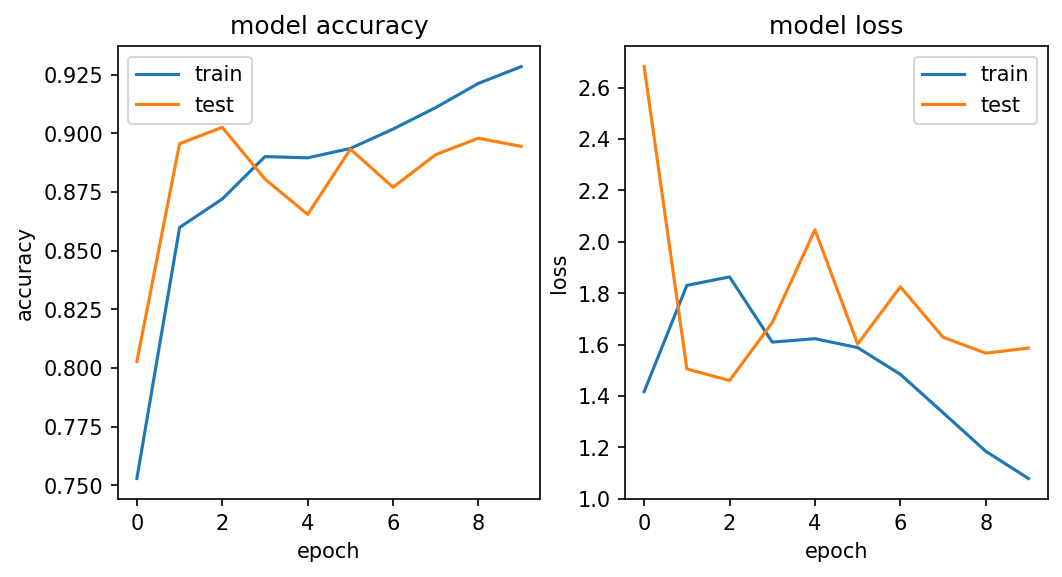

In [7]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(8, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper right')
